In [1]:
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2#正则化L2
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
normal_all = pd.read_csv(r'F:\张老师课题学习内容\code\数据集\试验数据(包括压力脉动和振动)\2013.9.12-未发生缠绕前\2013-9-12压力脉动\1450-txt\normal_0_通道10.txt')
chanrao_all = pd.read_csv(r'F:\张老师课题学习内容\code\数据集\试验数据(包括压力脉动和振动)\2013.9.17-发生缠绕后\压力脉动\1450-txt\chanrao_0_通道10.txt')  

normal=normal_all[["通道10"]]
chanrao=chanrao_all[["通道10"]]

In [3]:
#水泵的两种故障类型信号normal正常，chanrao故障
normal=normal.values.reshape(-1, 800)#(120000,1)-(150, 800)150条长度为800
chanrao=chanrao.values.reshape(-1, 800)
print(normal_all.shape,chanrao_all.shape)
print(normal.shape,chanrao.shape)

(120000, 2) (120000, 2)
(150, 800) (150, 800)


In [4]:
import numpy as np
def yuchuli(data,label):#(7:1)(616:88)
    #打乱数据顺序
    np.random.shuffle(data)
    train = data[0:120,:]
    test = data[120:150,:]
    label_train = np.array([label for i in range(0,120)])
    label_test =np.array([label for i in range(0,30)])
    return train,test ,label_train ,label_test

def stackkk(a,b,c,d,e,f,g,h):
    aa = np.vstack((a, e))
    bb = np.vstack((b, f))
    cc = np.hstack((c, g))
    dd = np.hstack((d, h))
    return aa,bb,cc,dd
x_tra0,x_tes0,y_tra0,y_tes0 = yuchuli(normal,0)
x_tra1,x_tes1,y_tra1,y_tes1 = yuchuli(chanrao,1)
tr1,te1,yr1,ye1=stackkk(x_tra0,x_tes0,y_tra0,y_tes0 ,x_tra1,x_tes1,y_tra1,y_tes1)

x_train=tr1
x_test=te1
y_train = yr1
y_test = ye1

#打乱数据
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)

state = np.random.get_state()
np.random.shuffle(x_test)
np.random.set_state(state)
np.random.shuffle(y_test)


#对训练集和测试集标准化
def ZscoreNormalization(x):
    """Z-score normaliaztion"""
    x = (x - np.mean(x)) / np.std(x)
    return x
x_train=ZscoreNormalization(x_train)
x_test=ZscoreNormalization(x_test)
# print(x_test[0])


#转化为一维序列
x_train = x_train.reshape(-1,800,1)
x_test = x_test.reshape(-1,800,1)
print(x_train.shape,x_test.shape)

def to_one_hot(labels,dimension=2):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results
one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)


(240, 800, 1) (60, 800, 1)


In [5]:
x = layers.Input(shape=[800,1,1])
Flatten=layers.Flatten()(x)
Dense1=layers.Dense(12, activation='relu')(Flatten)
Dense2=layers.Dense(6, activation='relu')(Dense1)
Dense3=layers.Dense(2, activation='softmax')(Dense2)
model = keras.Model(x, Dense3)    
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 1, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 12)                9612      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 14        
Total params: 9,704
Trainable params: 9,704
Non-trainable params: 0
_________________________________________________________________


In [6]:

#定义优化
model.compile(loss='categorical_crossentropy',
              optimizer='adam',metrics=['accuracy']) 

In [7]:
import time
time_begin = time.time()
history = model.fit(x_train,one_hot_train_labels,
                    validation_split=0.1,
                    epochs=50,batch_size=10,
                    shuffle=True)
time_end = time.time()
time = time_end - time_begin
print('time:', time)

Epoch 1/50
22/22 [==============================] - 2s 53ms/step - loss: 0.4050 - accuracy: 0.8133 - val_loss: 0.1392 - val_accuracy: 1.0000
Epoch 2/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0781 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0086 - val_accuracy: 1.0000
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 8/50
22/22 [=

In [8]:
import time
time_begin = time.time()
score = model.evaluate(x_test,one_hot_test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
 
time_end = time.time()
time = time_end - time_begin
print('time:', time)

Test loss: 0.0004491298459470272
Test accuracy: 1.0
time: 0.06606459617614746


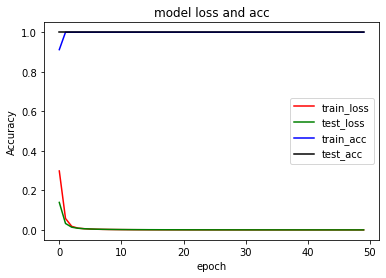

In [9]:
#绘制acc-loss曲线
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.plot(history.history['accuracy'],color='b')
plt.plot(history.history['val_accuracy'],color='k')
plt.title('model loss and acc')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss','train_acc', 'test_acc'], loc='center right')
# plt.legend(['train_loss','train_acc'], loc='upper left')
#plt.savefig('1.png')
plt.show()

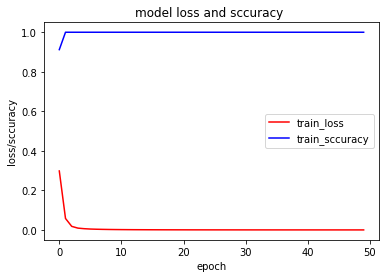

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['accuracy'],color='b')
plt.title('model loss and sccuracy ')
plt.ylabel('loss/sccuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_sccuracy'], loc='center right')
plt.show()